In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from model.backbone import *
from model.positional_encoding import *
from model.transformer import *
from dataset.preparator import prepare
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ticker = 'SPY'
seq_len = 40

path = prefix = 'macro'

df_train = pd.read_csv(f'data/processed/{path}/{prefix}_train.csv', index_col='Date')
df_val = pd.read_csv(f'data/processed/{path}/{prefix}_val.csv', index_col='Date')
df_test = pd.read_csv(f'data/processed/{path}/{prefix}_test.csv', index_col='Date')
X_train, y_train, X_val, y_val, X_test, y_test = prepare(path,prefix,seq_len, pca=False, task='reg', save=False)


['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9']
Training set shape (3814, 40, 10) (3814,)
Validation set shape (443, 40, 10) (443,)
Testing set shape (442, 40, 10) (442,)


In [5]:
instance = f'{ticker}_p3_macro_reg40_all'

14/14 [==============================] - 1s 39ms/step - loss: 1.7165 - mae: 0.9872 - mape: 130.5812
 
Evaluation metrics
Training Data - Loss: 1.2202, MAE: 0.7464, MAPE: 16805.8184
Validation Data - Loss: 2.1685, MAE: 0.9677, MAPE: 126.6943
Test Data - Loss: 1.7165, MAE: 0.9872, MAPE: 130.5812


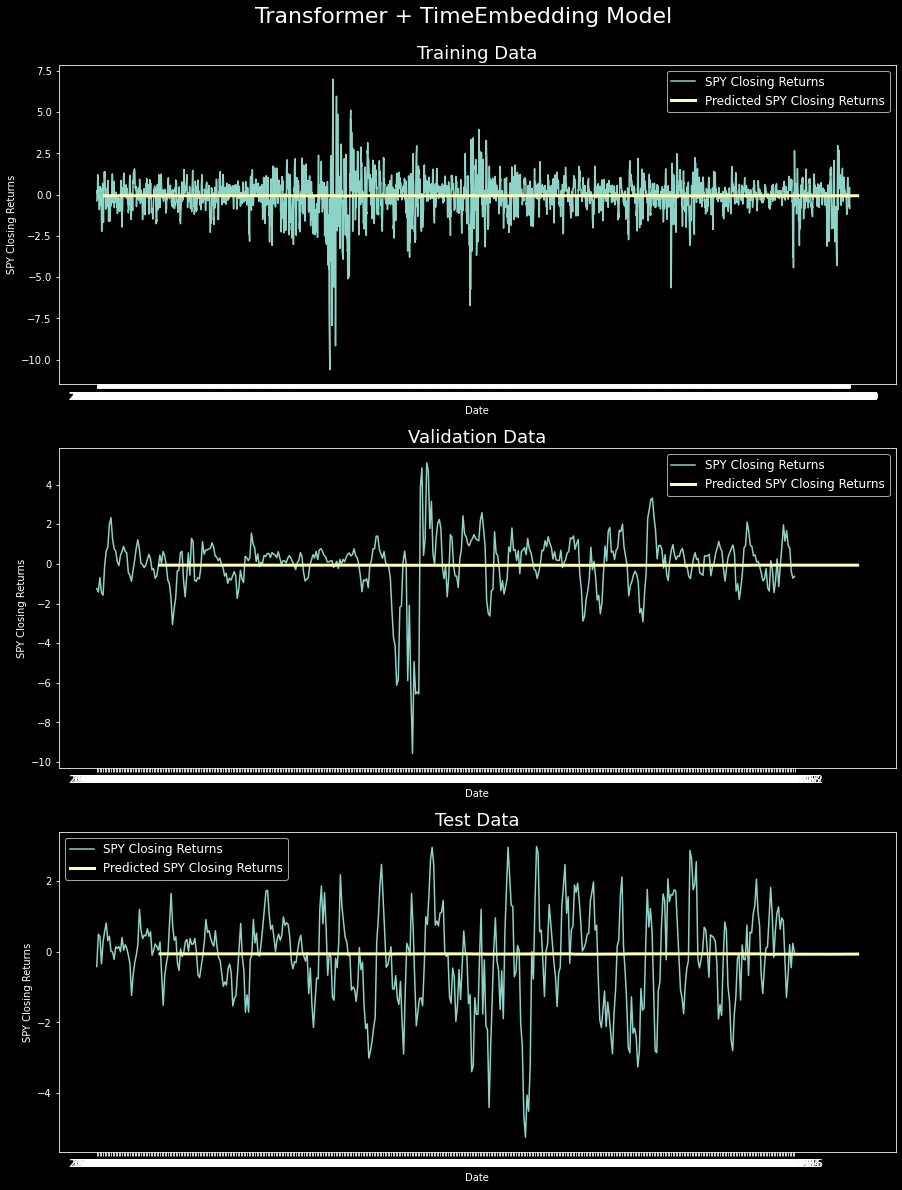

In [11]:

model = tf.keras.models.load_model(f'instances/{instance}.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder,
                                                   'LinearBackbone': LinearBackbone,
                                                   'ConvBackbone': ConvBackbone})

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(df_train.loc[:, 'close'], label=f'{ticker} Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel(f'{ticker} Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(df_val.loc[:, 'close'], label=f'{ticker} Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel(f'{ticker} Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(df_test.loc[:, 'close'], label=f'{ticker} Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel(f'{ticker} Closing Returns')
ax31.legend(loc="best", fontsize=12)

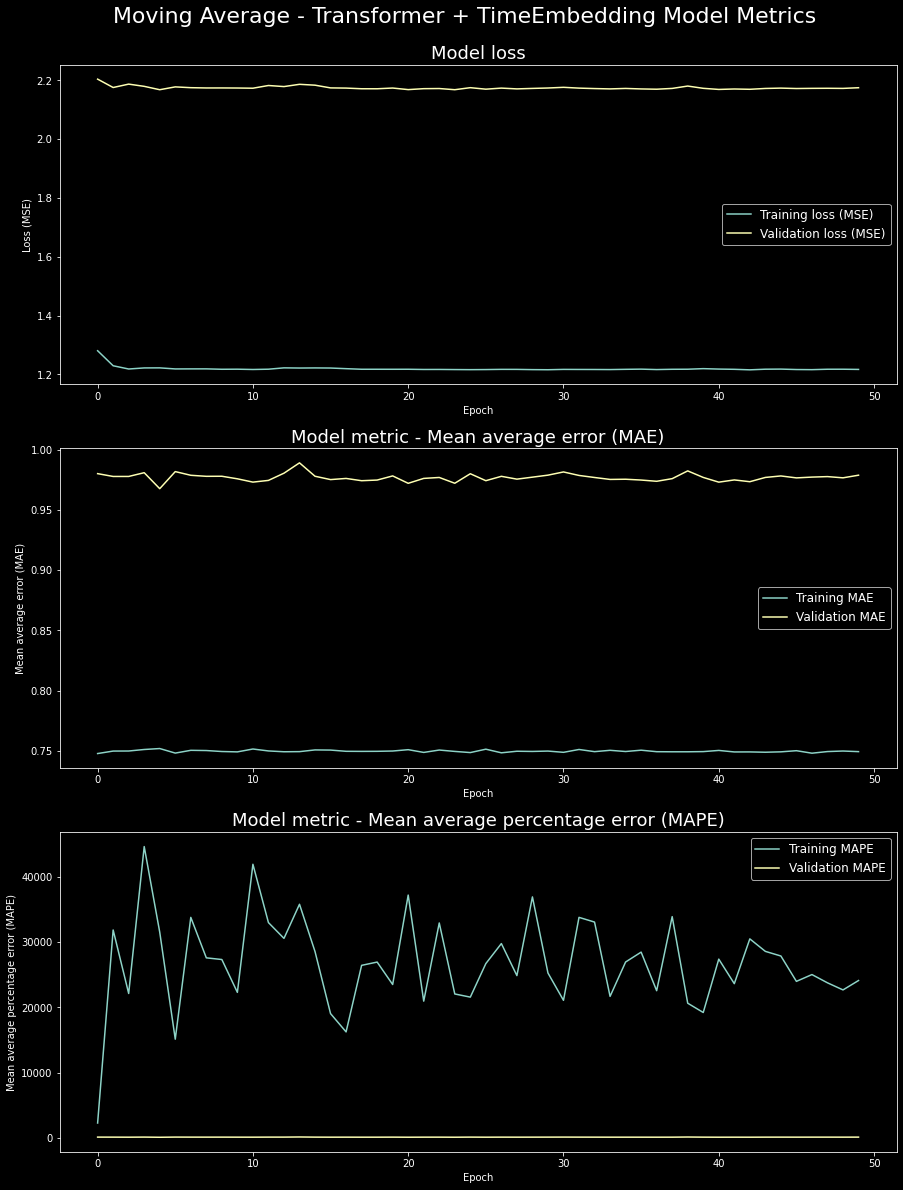

In [16]:
'''Display model metrics'''
import pickle
with open(f'instances\SPY_p3_macro_reg40_all_history.pickle','rb') as f: history = pickle.load(f)

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history['loss'], label='Training loss (MSE)')
ax1.plot(history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history['mae'], label='Training MAE')
ax2.plot(history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history['mape'], label='Training MAPE')
ax3.plot(history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [17]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def classifier_stats(Y, O):
  f1 = f1_score(Y, O)  

  cm = confusion_matrix(Y, O)
  tn, fp, fn, tp = cm.ravel()

  fpr = fp/(fp+tn)
  specificity = 1 - fpr

  fnr = fn/(fn+tp)
  recall = 1 - fnr

  pos_precision = tp/(tp+fp)
  neg_precision = tn/(tn+fn)

  print(f"{fpr = :.4f}, {specificity = :.4f}")
  print(f"{fnr = :.4f}, {recall = :.4f}")
  print(f"{pos_precision = :.4f}, {neg_precision = :.4f}")
  print(f"{f1 = }")

  cm_plot = sns.heatmap(cm, annot=True, fmt='.0f', cmap=sns.color_palette("light:#5A9", as_cmap=True))
  cm_plot.set(xlabel='Predicted', ylabel='True')
  plt.show()

In [18]:
from tabulate import tabulate
import plotly.graph_objects as go

class evaluation:
  def find_mdd(self, df):
    window = 252
    Roll_Max = self.balance.rolling(window, min_periods=1).max()
    Daily_Drawdown = self.balance/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()
    return Max_Daily_Drawdown.min()

  def __init__(self, df = None, name = None, static = False):
    if not static:
      self.initial_balance = 10000
      self.name = name
      self.no_trades = df.shape[0]
      self.ret = df['return']
      self.balance = np.cumprod(df['return']+1) * self.initial_balance
      self.cum_ret = (self.balance.iloc[-1]/self.balance.iloc[0]) - 1 
      self.win = df[df['return'] > 0]['return']
      self.lose = df[df['return'] < 0]['return']
      self.avg_win = self.win.mean()
      self.avg_lose = self.lose.mean()
      self.win_rate = self.win.shape[0] / (self.win.shape[0] + self.lose.shape[0])
      self.max_ret = (self.balance.max() / self.balance.iloc[0]) - 1
      self.days_trades = df.index[-1] - df.index[0]
      self.cagr = np.power(self.balance.iloc[-1]/self.balance.iloc[0], 1/(self.days_trades.days/365)) - 1
      self.sharpe = (self.cum_ret)/df['return'].std()
      self.mdd = self.find_mdd(df)
      self.date = df.index
      self.dic = dict()
  
  def get_dict(self):
    self.dic = {
        'name': self.name,
        'no_trades' : self.no_trades,
        'cum_ret' : "{0:.3f}%".format(self.cum_ret * 100),
        'win_rate' : "{0:.3f}%".format(self.win_rate * 100),
        'Avg. Win' : "{0:.3f}%".format(self.avg_win * 100),
        'Avg. Lose' : "{0:.3f}%".format(self.avg_lose * 100),
        'Max Return': "{0:.3f}%".format(self.max_ret * 100),
        'CAGR': "{0:.3f}%".format(self.cagr * 100),
        'Sharpe Ratio': "{0:.3f}".format(self.sharpe),
        'MDD': "{0:.3f}%".format(self.mdd * 100),
        'trade_turnover': "{0:.3f}".format(self.days_trades.days/self.no_trades)
    }
    return self.dic
  
  def tabulate(self, list_eval):
    list_dic = []
    for eval in list_eval:
      list_dic.append(eval.get_dict())
    compiled = dict()
    for key in list_dic[0].keys():
      compiled[key] = dict()
      for dic in list_dic:
          compiled[key][dic['name']] = dic[key]
    df_compiled = pd.DataFrame(compiled)
    names = []
    for dic in list_dic:
      names.append(dic['name'])
    print(tabulate(df_compiled.T, headers=names))
  
  def get_chart(self, list_eval):
    fig = go.Figure()
    for eval in list_eval:
      fig.add_trace(go.Scatter(x=eval.date, y=eval.balance,
                               mode='lines',
                               name=eval.name))
      fig.update_layout(
          width = 1000,
          title=f'{ticker.upper()} trading balance'
      )
    fig.show()

In [19]:
df_train = df_train.iloc[seq_len-1:,]
df_val = df_val.iloc[seq_len-1:,]
df_test = df_test.iloc[seq_len-1:,]

df_train['pred'] = train_pred
df_val['pred'] = val_pred
df_test['pred'] = test_pred

ValueError: Length of values (3814) does not match length of index (3736)

In [20]:
df_test

,open,high,low,close,volume,^IRX,^TNX,^TYX,CL=F,GC=F,...,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,Y_reg
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-08,-0.337792,-0.357229,-0.421152,-0.253249,0.312686,-0.041590,0.561811,0.543278,0.125984,-0.522454,...,0.229360,0.225947,0.014835,-0.383161,0.091462,0.014075,-0.016664,0.031085,-0.071105,-0.609724
2021-09-09,-0.442045,-0.361678,-0.472786,-0.609724,0.669768,-0.611934,0.119465,-0.105881,-0.545160,-0.309786,...,0.552680,0.255802,0.067885,0.099846,0.036192,-0.081352,-0.069575,-0.123348,0.121019,-0.980736
2021-09-10,-0.257565,-0.441292,-0.790633,-0.980736,1.419096,-0.611934,0.344773,-0.088429,0.051331,-0.880108,...,1.163723,0.286494,-0.730889,-0.352468,0.123869,-0.413756,-0.195307,-0.197374,0.002275,-0.857211
2021-09-13,-0.522501,-0.751529,-0.916063,-0.857211,1.254875,-0.611934,0.068795,-0.516642,0.240568,-0.833990,...,0.963010,-0.202384,-0.729400,-0.462660,0.294395,-0.167056,-0.195875,-0.324977,-0.129834,-0.945619
2021-09-14,-0.660117,-0.723477,-0.925847,-0.945619,0.896829,-0.041590,-1.471478,-1.929578,0.491914,0.075732,...,0.668730,-1.356401,-0.625410,-0.305063,0.370498,-0.128662,-0.228455,-0.228813,-0.007618,-0.484329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10,-0.849966,-1.306724,-0.836425,-0.666536,-0.556773,0.232464,1.302430,1.568736,1.451267,-0.095157,...,-0.934661,-1.299270,-0.348111,0.015413,0.394566,-0.070256,0.293936,0.163971,-0.317270,0.196172
2023-02-13,-0.284026,0.037931,-0.126740,0.196172,0.170077,0.231864,0.524978,0.952467,1.368222,-0.358970,...,-0.250891,-0.239312,-1.277630,-0.395097,-0.157266,0.360895,0.100476,0.289230,0.040304,-0.456162
2023-02-14,0.133341,-0.372482,-0.035296,-0.456162,-0.039785,0.176800,0.542790,0.779599,0.385862,-0.421407,...,-0.193079,0.239749,-0.232425,-0.375592,-0.509172,-0.459468,0.222615,0.025199,-0.087184,0.234190


In [21]:
avg = 5

O = (df_test['pred'] > df_test['close']) & df_test['!close_pct'].shift(avg-1) > 0
Y = df_test['!close_pct'].shift(-1) > 0
classifier_stats(Y,O)

KeyError: 'pred'

In [12]:
df_trade = df_test
df_trade.index = pd.to_datetime(df_trade.index)
df_trade['close_pct_tmr'] = df_trade['!close_pct'].shift(-1)
df_trade['open_tmr'] = df_trade['!open'].shift(-1)
df_trade = df_trade.iloc[:-1,:]

In [13]:
def process_condition(long_cond = None, short_cond = None, risk = None, buy_hold = False, comission=None, sl_cond=True, rf=None, open=False):
  open_sl_count = 0
  open_sl = False
  if not buy_hold:
    if rf != None:
      risk_free = rf
    else:
      risk_free = 0
    leverage = 1
    trades = df_trade[long_cond | short_cond]
    if open:
      trades['down_tmr'] = (trades['!low'].shift(-1) - trades['open_tmr'])/trades['open_tmr']
      trades['up_tmr'] = (trades['open_tmr'] - trades['open_tmr'])/trades['open_tmr']
    else:
      trades['down_tmr'] = (trades['!low'].shift(-1) - trades['!close'])/trades['!close']
      trades['up_tmr'] = (trades['!close'] - trades['!high'].shift(-1))/trades['!close']
      trades['open_close_tmr'] = (trades['open_tmr'] - trades['!close'])/trades['!close']
    long = 0
    short = 0
    no_trade = 0
    trades['return'] = 0
    trades.dropna(inplace=True)
    stop_loss = risk
    for i in range(trades.shape[0]): 
      stop_col = 'down_tmr' if trades.loc[trades.index[i], 'pred'] - trades.loc[trades.index[i], 'close']> 0 else 'up_tmr'
      if sl_cond:
        if trades.loc[trades.index[i], stop_col] > stop_loss:  
          if stop_col == 'down_tmr':
            if comission != None:
              ret = ((1 + trades.loc[trades.index[i], 'close_pct_tmr']) * np.power((1-comission),2)) - 1
            else:  
              ret = (trades.loc[trades.index[i], 'close_pct_tmr'])
            trades.loc[trades.index[i], 'return'] = ret if ret > stop_loss else stop_loss
            long += 1
          if stop_col == 'up_tmr':
            if comission != None:
              ret = risk_free + leverage * (risk_free + ((1 + -1*(trades.loc[trades.index[i], 'close_pct_tmr'])) * np.power((1-comission),2)) - 1)
            else:
              ret = risk_free + leverage * (risk_free + -1*(trades.loc[trades.index[i], 'close_pct_tmr']))
            trades.loc[trades.index[i], 'return'] = ret if ret > stop_loss else stop_loss
            short += 1
        else: 
          ret = min(stop_loss, trades.loc[trades.index[i], 'open_close_tmr']*(1 if stop_col=='down_tmr' else -1))
          if comission != None:
            ret = ((1+ret)* np.power((1-comission),2)) - 1
          # else:
          #   ret = stop_loss
          trades.loc[trades.index[i], 'return'] = ret #if ret > stop_loss else stop_loss
      else: #no_stop_loss
        if stop_col == 'down_tmr':
          if comission != None:
            trades.loc[trades.index[i], 'return'] = ((1 + trades.loc[trades.index[i], 'close_pct_tmr']) * np.power((1-comission),2)) - 1
          else:  
            trades.loc[trades.index[i], 'return'] = (trades.loc[trades.index[i], 'close_pct_tmr'])
          long += 1
        if stop_col == 'up_tmr':
          if comission != None:
            trades.loc[trades.index[i], 'return'] = risk_free + leverage * (risk_free + ((1 + -1*(trades.loc[trades.index[i], 'close_pct_tmr'])) * np.power((1-comission),2)) - 1)
          else:
            trades.loc[trades.index[i], 'return'] = risk_free + leverage * (risk_free + -1*(trades.loc[trades.index[i], 'close_pct_tmr']))
          short += 1
    
    # if sl_cond:
    #   if comission:
    #     trades.loc[trades['return'] < ((1+stop_loss)* np.power((1-comission),2)) - 1, 'return'] = ((1+stop_loss)* np.power((1-comission),2)) - 1
    #   else:
    #     trades.loc[trades['return'] < stop_loss, 'return'] = stop_loss
    
  else: # Buy and hold
    trades = df_trade
    trades['return'] = trades['close_pct_tmr']
  trades['date'] = trades.index
  return trades

In [14]:
# With short and long and checking
list_eval = []
risk = -0.0001
comission = 0.00005
long_cond = (df_trade['pred'] - df_trade['close'] > 0) & (df_trade['!close_pct'].shift(avg-1) > 0)
short_cond = (df_trade['pred'] - df_trade['close'] < 0) & (df_trade['!close_pct'].shift(avg-1) < 0)

original = process_condition(long_cond, short_cond, risk, sl_cond=False)
original_eval = evaluation(original, 'original')
list_eval.append(original_eval)

original_comission = process_condition(long_cond, short_cond, risk, sl_cond=False, comission=comission)
original_comission_eval = evaluation(original_comission, 'original_comission')
list_eval.append(original_comission_eval)

original_stoploss = process_condition(long_cond, short_cond, risk)
original_stoploss_eval = evaluation(original_stoploss, 'original_stoploss')
list_eval.append(original_stoploss_eval)

original_stoploss_comission = process_condition(long_cond, short_cond, risk, comission=comission)
original_stoploss_comission_eval = evaluation(original_stoploss_comission, 'original_stoploss_comission')
list_eval.append(original_stoploss_comission_eval)


# long_cond = (df_trade['pred'] - df_trade['close'] > 0 )
# short_cond = (df_trade['pred'] - df_trade['close'] < 0 )

# reckless = process_condition(long_cond, short_cond, risk)
# reckless_eval = evaluation(reckless, 'reckless_stoploss')
# list_eval.append(reckless_eval)

# reckless_comission = process_condition(long_cond, short_cond, risk, comission=comission)
# reckless_comission_eval = evaluation(reckless_comission, 'reckless_stoploss_comission')
# list_eval.append(reckless_comission_eval)


buy_hold = process_condition(buy_hold=True)
buy_hold_eval = evaluation(buy_hold, 'buy_and_hold')
list_eval.append(buy_hold_eval)

evaluation(static=True).tabulate(list_eval)
evaluation(static=True).get_chart(list_eval)

                original    original_comission    original_stoploss    original_stoploss_comission    buy_and_hold
--------------  ----------  --------------------  -------------------  -----------------------------  --------------
name            original    original_comission    original_stoploss    original_stoploss_comission    buy_and_hold
no_trades       183         183                   183                  183                            471
cum_ret         11.044%     9.041%                13.363%              11.396%                        0.416%
win_rate        52.198%     51.913%               24.044%              24.044%                        50.213%
Avg. Win        0.981%      0.971%                1.339%               1.329%                         0.941%
Avg. Lose       -0.937%     -0.936%               -0.327%              -0.337%                        -0.931%
Max Return      13.909%     11.899%               14.380%              12.452%                        17.492%

# Results

### Robust Scalar Gmean

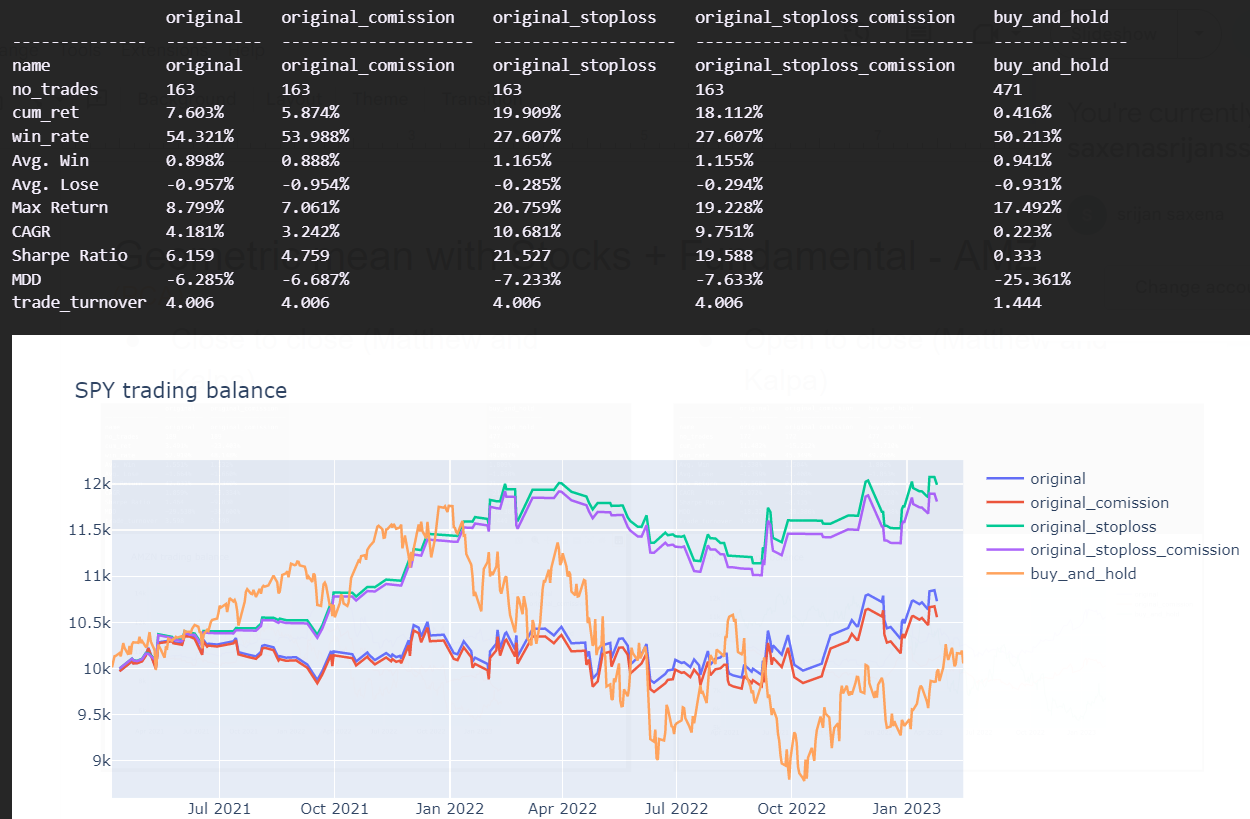

### Macro

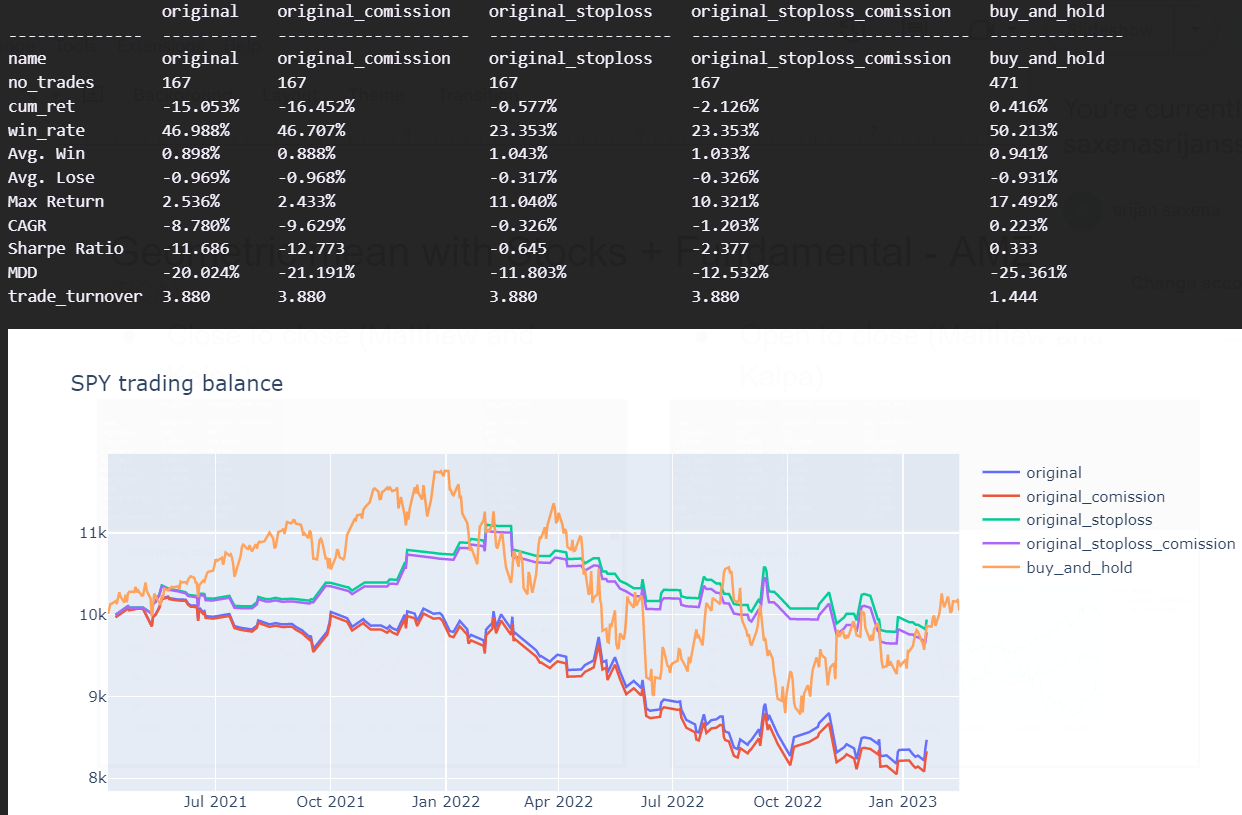

### Macro PCA

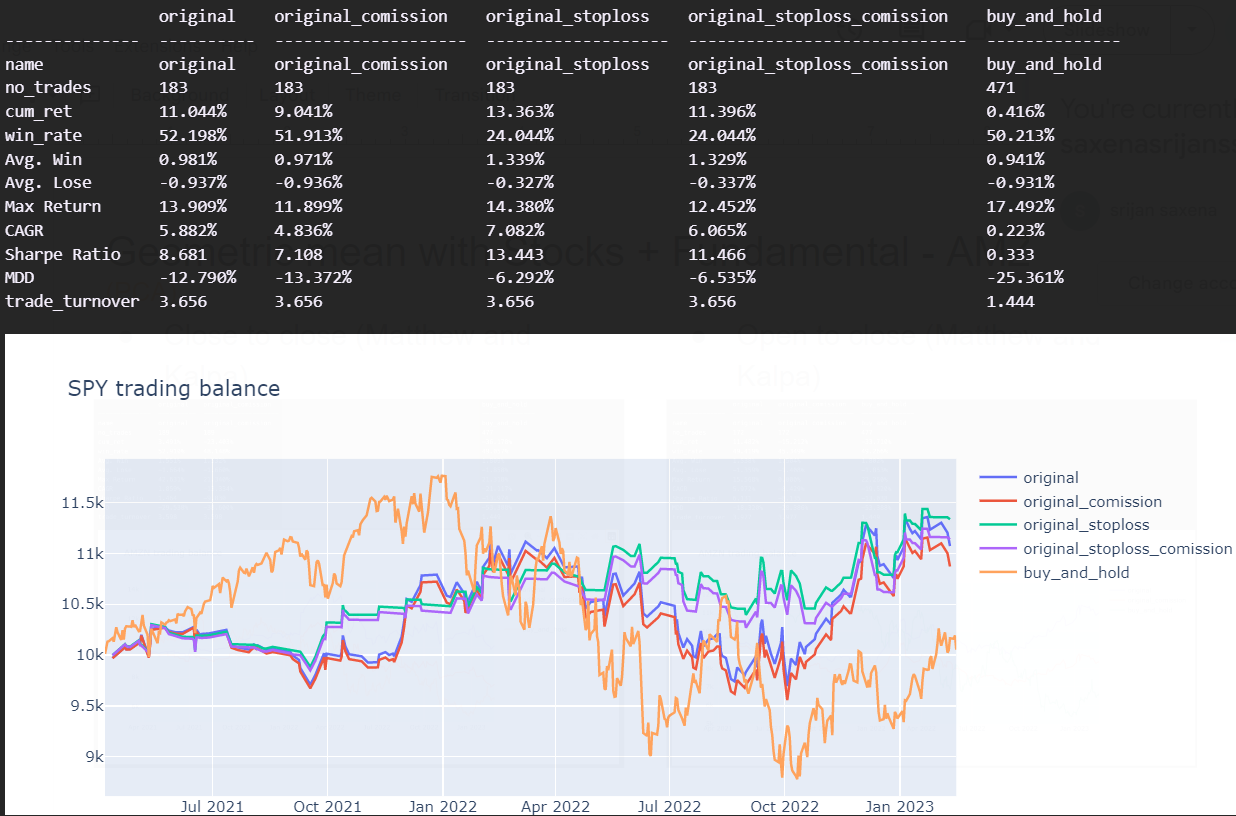